In [1]:
import numpy as np
from numpy import genfromtxt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import GPy

import pickle

plots_path = "./../../figures/gp_regression/"

In [2]:
# Loading the data.
path = "./../../data/gp_regression/"

Xtrain = genfromtxt(path + "\Xtrain.csv", delimiter=',', skip_header=1)
Xtest = genfromtxt(path + "\Xtest.csv", delimiter=',', skip_header=1)

Ytrain = genfromtxt(path + "\Ytrain2.csv", delimiter=',', skip_header=1)
Ytest = genfromtxt(path + "\Ytest2.csv", delimiter=',', skip_header=1)

Ytrain = np.array([Ytrain]).T
Ytest = np.array([Ytest]).T

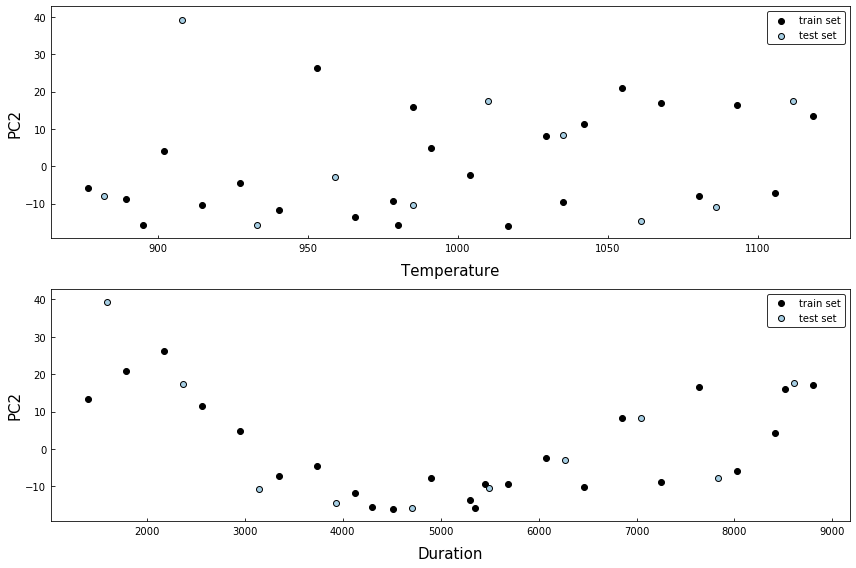

In [3]:
# Visualizing the initial data.

fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].scatter(x = Xtrain[:,0], y = Ytrain, marker='o', c='black', edgecolor='black', label='train set')
ax[0].scatter(x = Xtest[:,0], y = Ytest, marker='o', c='#a6cee3', edgecolor='black', label='test set')

ax[0].set_xlabel("Temperature", fontsize=15, labelpad=10, horizontalalignment='center')
ax[0].set_ylabel("PC2", fontsize=15, labelpad=3, horizontalalignment='center')

ax[0].tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)
ax[0].legend(loc='best', fontsize=10, edgecolor='black')

ax[1].scatter(x = Xtrain[:,1], y = Ytrain, marker='o', c='black', edgecolor='black', label='train set')
ax[1].scatter(x = Xtest[:,1], y = Ytest, marker='o', c='#a6cee3', edgecolor='black', label='test set')

ax[1].set_xlabel("Duration", fontsize=15, labelpad=10, horizontalalignment='center')
ax[1].set_ylabel("PC2", fontsize=15, labelpad=3, horizontalalignment='center')

ax[1].tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)

ax[1].legend(loc='best', fontsize=10, edgecolor='black')

plt.tight_layout()

#plt.savefig(plots_path + 'data-visualization_b.png', facecolor='w', dpi=600)
plt.show()

In [4]:
# Normalizing the input data. /// Standardizing the output data.
norm_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

Xtrain = norm_scaler.fit_transform(Xtrain)
Xtest = norm_scaler.transform(Xtest)

Ytrain = standard_scaler.fit_transform(Ytrain)
Ytest = standard_scaler.transform(Ytest)
#print(Xtrain)

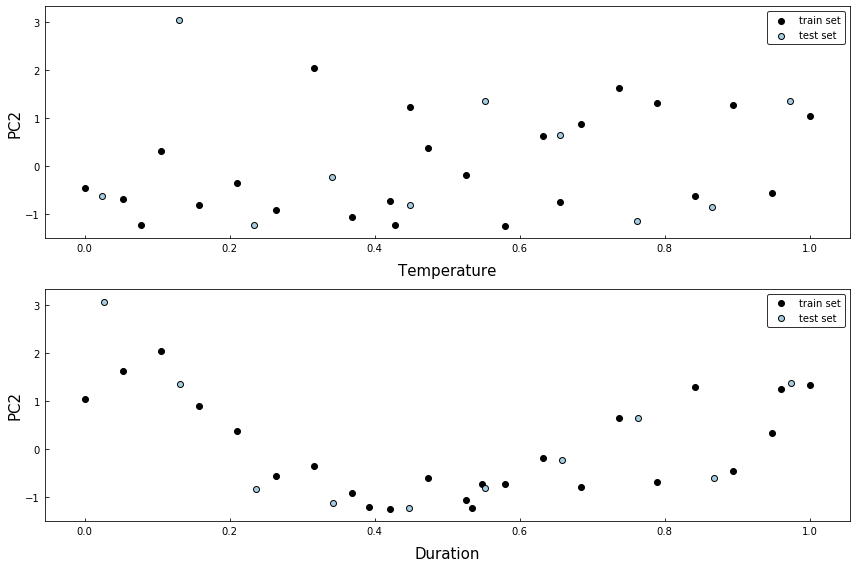

In [5]:
# Visualizing the data.

fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].scatter(x = Xtrain[:,0], y = Ytrain, marker='o', c='black', edgecolor='black', label='train set')
ax[0].scatter(x = Xtest[:,0], y = Ytest, marker='o', c='#a6cee3', edgecolor='black', label='test set')

ax[0].set_xlabel("Temperature", fontsize=15, labelpad=10, horizontalalignment='center')
ax[0].set_ylabel("PC2", fontsize=15, labelpad=3, horizontalalignment='center')

ax[0].tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)
ax[0].legend(loc='best', fontsize=10, edgecolor='black')

ax[1].scatter(x = Xtrain[:,1], y = Ytrain, marker='o', c='black', edgecolor='black', label='train set')
ax[1].scatter(x = Xtest[:,1], y = Ytest, marker='o', c='#a6cee3', edgecolor='black', label='test set')

ax[1].set_xlabel("Duration", fontsize=15, labelpad=10, horizontalalignment='center')
ax[1].set_ylabel("PC2", fontsize=15, labelpad=3, horizontalalignment='center')

ax[1].tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)

ax[1].legend(loc='best', fontsize=10, edgecolor='black')

plt.tight_layout()

#plt.savefig(plots_path + 'data-visualization_b2.png', facecolor='w', dpi=600)
plt.show()

In [6]:
#Our initial kernels.
ks = [
    GPy.kern.RBF(2, ARD=True),                #0
    GPy.kern.Matern32(2, ARD=True),           #1
    #========================#
    GPy.kern.RBF(1, active_dims=[0]),         #2
    GPy.kern.RBF(1, active_dims=[1]),         #3
    GPy.kern.Matern32(1, active_dims=[0]),    #4
    GPy.kern.Matern32(1, active_dims=[1]),    #5
    GPy.kern.Exponential(2, ARD=True),        #6
    GPy.kern.StdPeriodic(1, active_dims=[0]), #7
    GPy.kern.StdPeriodic(1, active_dims=[1])  #8
]

In [7]:
#Constructing some 2-D kernels by multiplying others.

k0 = ks[0] #SE-ARD

k1 = ks[1] #Matern ARD

k2 = ks[2] * ks[5] #RBF[0]*Matern[1]
k3 = ks[3] * ks[4] #RBF[1]*Matern[0]

k4 = ks[0] * ks[6] #RBF*Exponential
k5 = ks[1] * ks[6] #Matern*Exponential

k6 = ks[0] * (ks[7] + ks[8]) #RBF*Periodic
k7 = ks[1] * (ks[7] + ks[8]) #Matern*Periodic

In [8]:
### Function for kernel plotting.

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("mako"))

def plot_kern(kernel):
    z = []
    x = []
    y = []
    
    n = np.linspace(-4, 4, 100)
    e0 = np.linspace(-4, 4, 100)
    
    for n_value in n:
        for e0_value in e0:
            x.append(n_value)
            y.append(e0_value)
            z.append(kernel.K(np.array([[n_value,e0_value],[1.,1.]]))[0][1])

    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')

    ax.plot_trisurf(x, y, z,
                    linewidth = 1,
                    antialiased = True,
                    cmap=my_cmap);
    
    ax.set_xlabel('input $x_1$', fontsize=15)
    ax.set_ylabel('input $x_2$', fontsize=15)
    ax.set_zlabel('Covariance', fontsize=15)
    
    plt.tight_layout()
    #plt.savefig(plots_path + 'kernel_b.png', facecolor='w', dpi=600)
    
    plt.show()

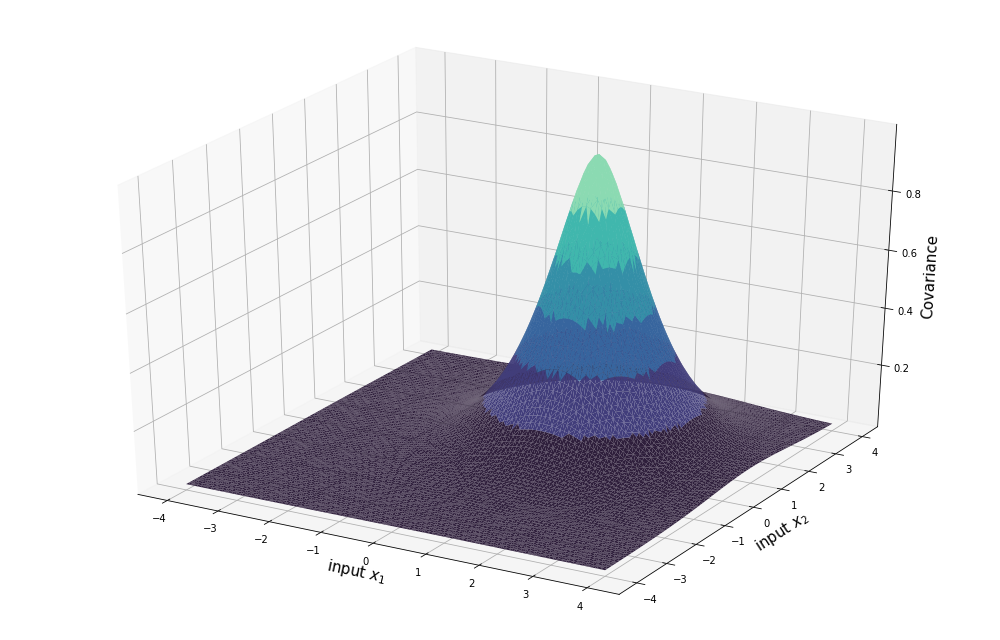

In [9]:
# plotting the initial kernel
plot_kern(k1)

In [10]:
# Specifying the model.

m = GPy.models.GPRegression(Xtrain, Ytrain, k0)   #main model

### ====================================== ###

m1 = GPy.models.GPRegression(Xtrain, Ytrain, k1)
m2 = GPy.models.GPRegression(Xtrain, Ytrain, k2)
m3 = GPy.models.GPRegression(Xtrain, Ytrain, k3)
m4 = GPy.models.GPRegression(Xtrain, Ytrain, k4)
m5 = GPy.models.GPRegression(Xtrain, Ytrain, k5)
m6 = GPy.models.GPRegression(Xtrain, Ytrain, k6)
m7 = GPy.models.GPRegression(Xtrain, Ytrain, k7)

models=[m, m1, m2, m3, m4, m5, m6, m7]
#for model in models:
#   model.Gaussian_noise.variance = 0.05
#    model.Gaussian_noise.variance.fix()

print(m)
print(m.rbf.lengthscale)


Name : GP regression
Objective : 35.09362508254744
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (2,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     1.00000000  |      +ve      |        
  [1]    |                     1.00000000  |      +ve      |        


In [11]:
# Optimization.
m.optimize()

# Optimizing the kernel parameters of the rest of the models.
for model in models:
    model.optimize()
    model.optimize_restarts(5, robust=True)
    
print(m1)
print(m1.Mat32.lengthscale)

Optimization restart 1/5, f = 6.8759948947194225
Optimization restart 2/5, f = 6.875994895107475
Optimization restart 3/5, f = 6.8759948947649345
Optimization restart 4/5, f = 33.51855987498349
Optimization restart 5/5, f = 6.875994894817401
Optimization restart 1/5, f = 9.642766221749264
Optimization restart 2/5, f = 9.642766242272739
Optimization restart 3/5, f = 9.642766235818435
Optimization restart 4/5, f = 9.642766235160295
Optimization restart 5/5, f = 9.64276622293667
Optimization restart 1/5, f = 9.391838567764065
Optimization restart 2/5, f = 9.391838920278495
Optimization restart 3/5, f = 9.391838579226828
Optimization restart 4/5, f = 9.391838536718156
Optimization restart 5/5, f = 9.39183859814129
Optimization restart 1/5, f = 7.2362923503067655
Optimization restart 2/5, f = 7.236292350293658
Optimization restart 3/5, f = 7.23629235030497
Optimization restart 4/5, f = 7.236292353759826
Optimization restart 5/5, f = 7.236292351114271
Optimization restart 1/5, f = 5.96555267

In [12]:
# Saving the model.
models_path = "./models/"
with open(models_path + "gp_model_b" , "wb") as f:
     pickle.dump(m, f)

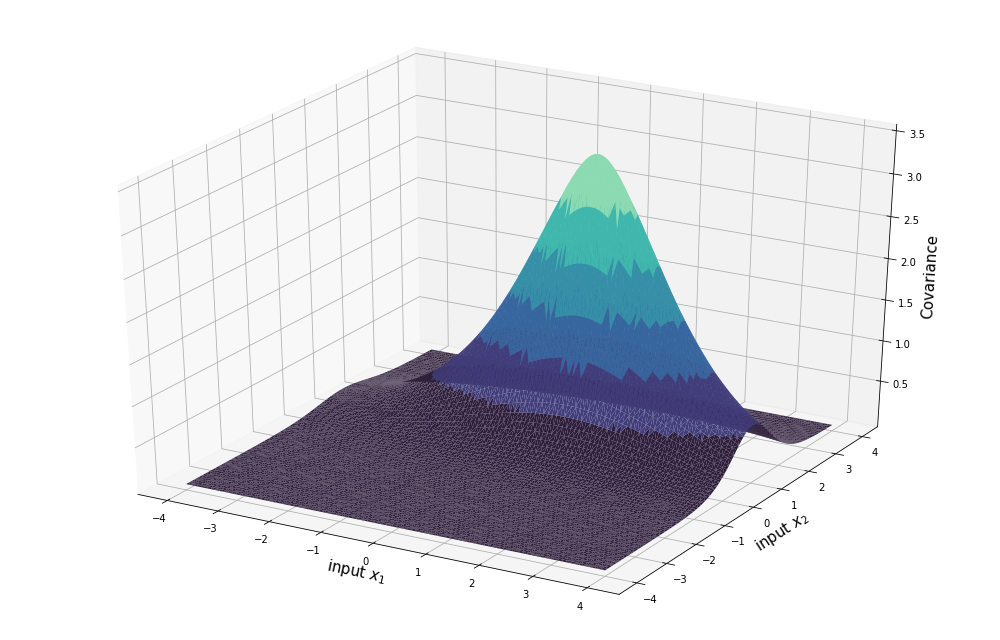

In [13]:
# Plotting the main kernel
plot_kern(k1)

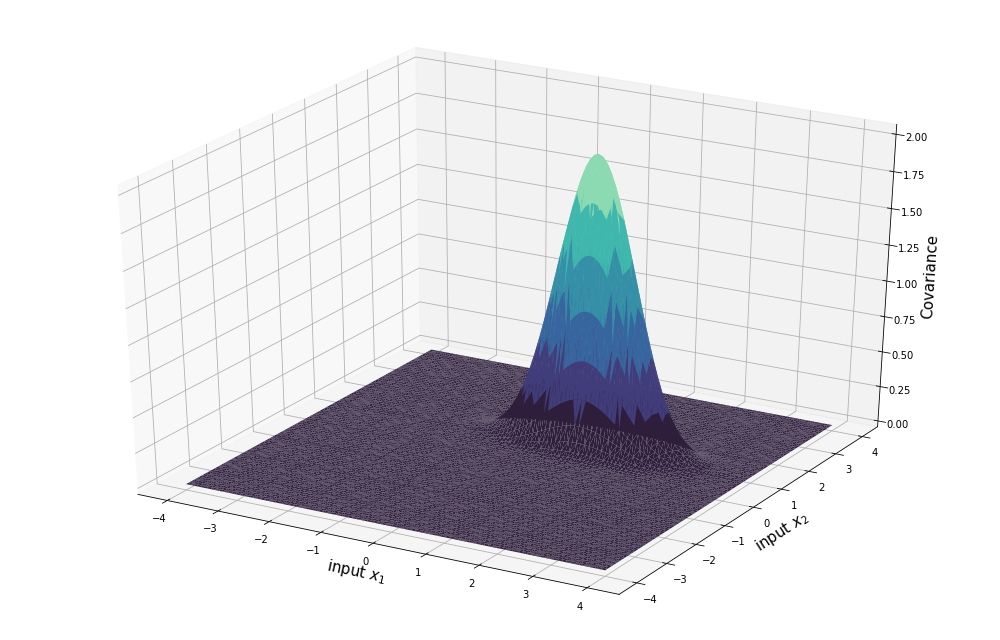

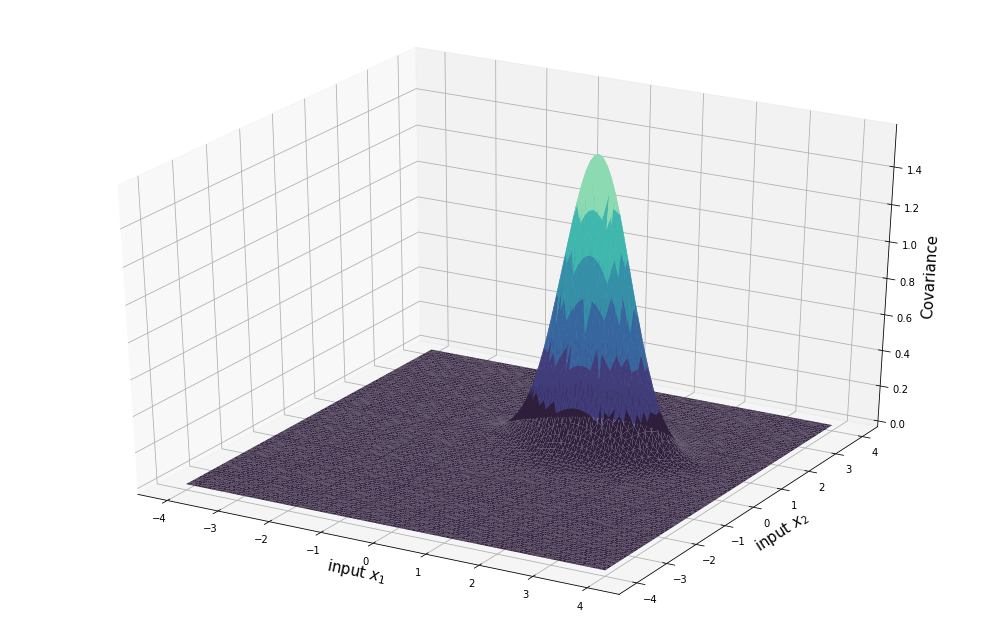

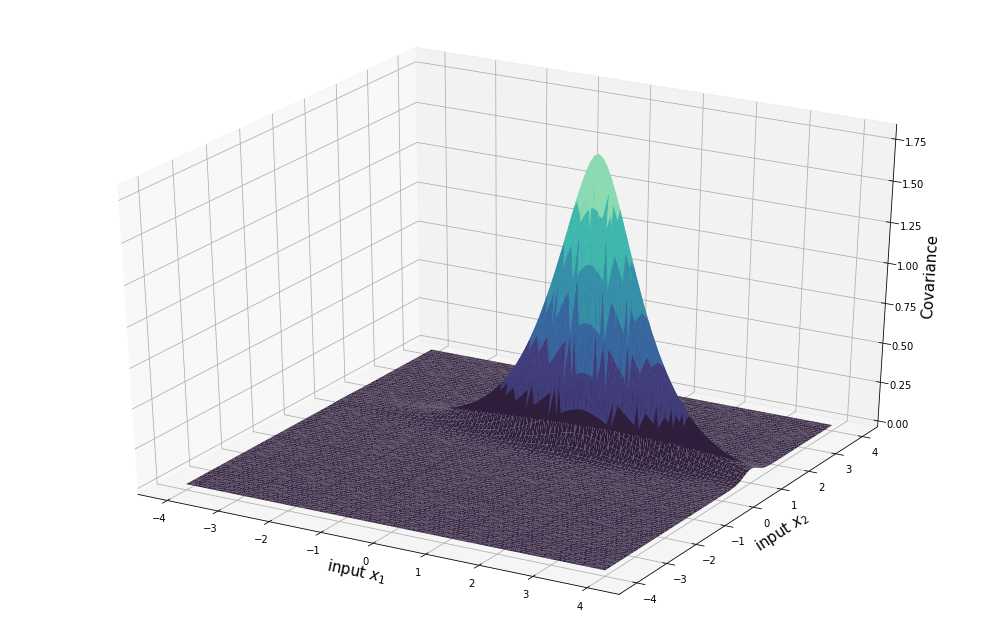

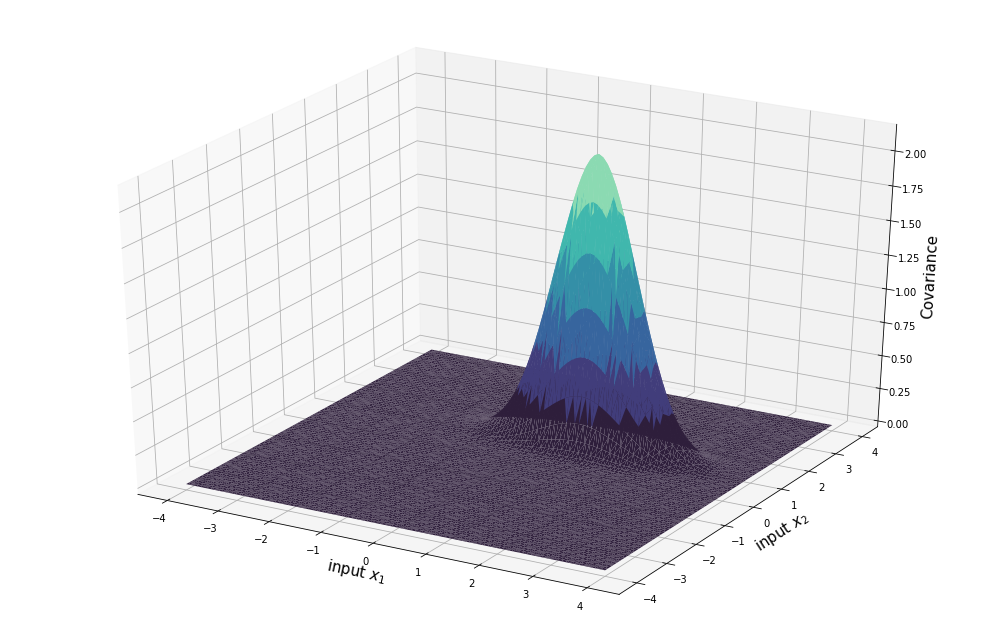

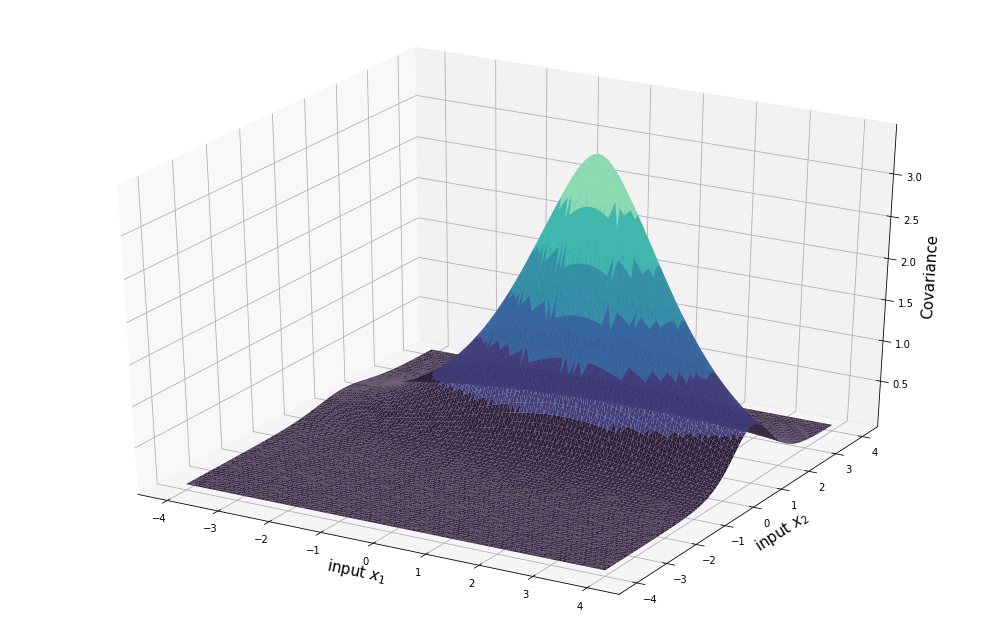

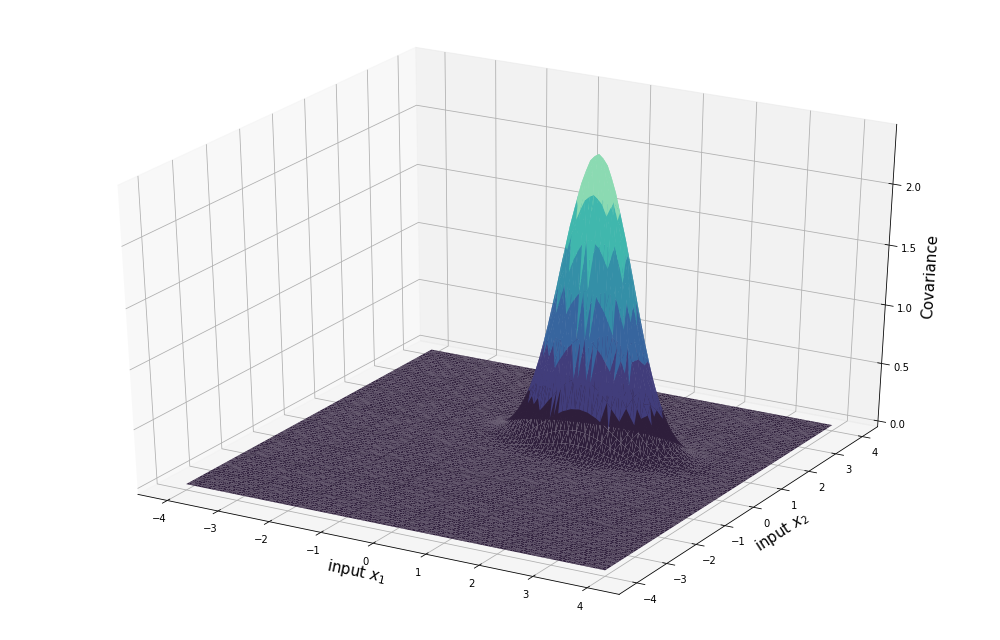

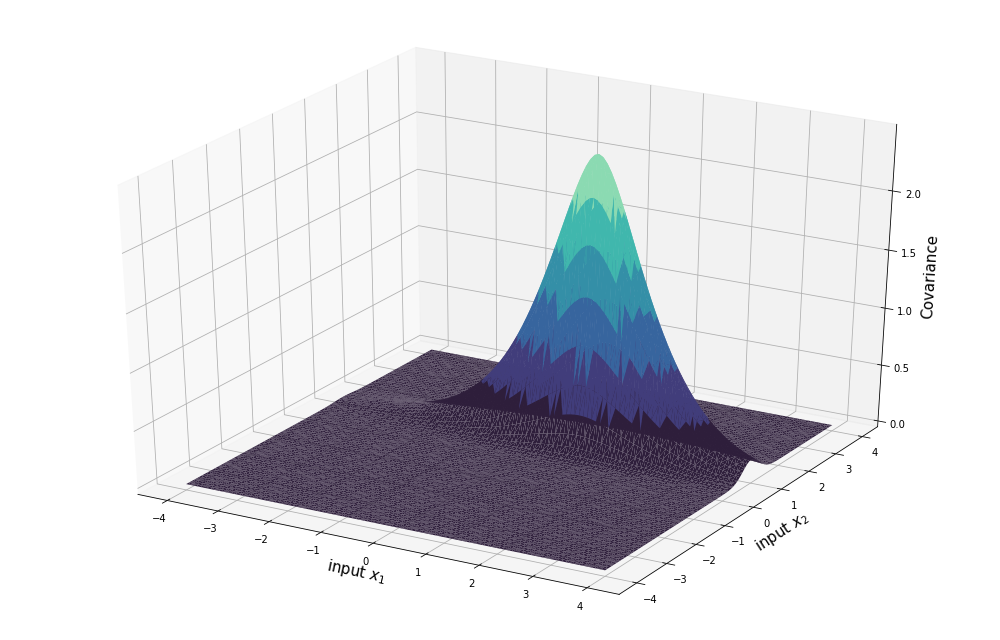

In [14]:
# Plotting the rest of the kernels.
kernels = [k0, k2, k3, k4, k5, k6, k7]
for kernel in kernels:
    plot_kern(kernel)

In [15]:
#Creating a grid.
[Xi, Xj] = np.meshgrid(np.linspace(0, 1, 300), np.linspace(0, 1, 300))
#Transforming our grid to a list of coordinates.
Xnew = np.vstack((Xi.ravel(), Xj.ravel())).T

In [16]:
#Calculating the mean and the covariance at the grid.
mean, cov = m1.predict_noiseless(Xnew, full_cov=False)

In [17]:
#Calculating the mean and the covariance for the rest of the models.
mean1, cov1 = m.predict_noiseless(Xnew, full_cov=False)
mean2, cov2 = m2.predict_noiseless(Xnew, full_cov=False)
mean3, cov3 = m3.predict_noiseless(Xnew, full_cov=False)
mean4, cov4 = m4.predict_noiseless(Xnew, full_cov=False)
mean5, cov5 = m5.predict_noiseless(Xnew, full_cov=False)
mean6, cov6 = m6.predict_noiseless(Xnew, full_cov=False)
mean7, cov7 = m7.predict_noiseless(Xnew, full_cov=False)

means=[mean, mean1, mean2, mean3, mean4, mean5, mean6, mean7]
covs=[cov, cov1, cov2, cov3, cov4, cov5, cov6, cov7]

In [18]:
#Function for plotting the mean and the variance of a gp model.

def plot_meanvar(mean, cov):
    my_cmap_b="YlGnBu_r"
    fin_fig=plt.figure(figsize=(12, 15))

    # left plot - mean of gp fit
    ax1 = plt.subplot(211)

    # mean surface
    pcm1 = ax1.pcolor(Xi, Xj, mean.reshape(Xi.shape), cmap=my_cmap_b)

    # sample locations
    ax1.plot(Xtrain[:, 0], Xtrain[:, 1], 'o', color='blue'), ax1.axis("square")
    ax1.plot(Xtest[:,0], Xtest[:,1], 'o', color='red')

    # annotations
    ax1.set_title("$\it{Mean}$", fontsize=30)
    fin_fig.colorbar(pcm1, ax=ax1)

    label_size = 15
    plt.tick_params(axis='both', which='both', labelsize=15, direction="in", pad=5)

    # right plot - variance of the gp
    ax2 = plt.subplot(212, sharex = ax1)

    # variance surface
    pcm2 = ax2.pcolor(Xi, Xj, cov.reshape(Xi.shape), cmap=my_cmap_b)

    # sample locations
    ax2.plot(Xtrain[:,0], Xtrain[:,1], 'o', color='blue'), ax2.axis("square")
    ax2.plot(Xtest[:,0], Xtest[:,1], 'o', color='red')

    # annotations
    ax2.set_title("$\it{Variance}$", fontsize=30)
    fin_fig.colorbar(pcm2, ax=ax2)

    plt.rcParams['xtick.labelsize'] = label_size
    plt.rcParams['ytick.labelsize'] = label_size
    plt.tick_params(axis="both", size=10, direction="in", pad=8)

    plt.xlabel("$X_1$", fontsize=30, labelpad=10, horizontalalignment='center')

    plt.tight_layout()
    #plt.tick_params(axis='both', which='both', labelsize=20, direction="in", pad=5
    fin_fig.text(0.2, 0.5, "$X_2$", fontsize=30, ha='center', va='center', rotation='vertical')

    #plt.savefig(plots_path + 'mean-variance_b.png', facecolor='w', dpi=600)

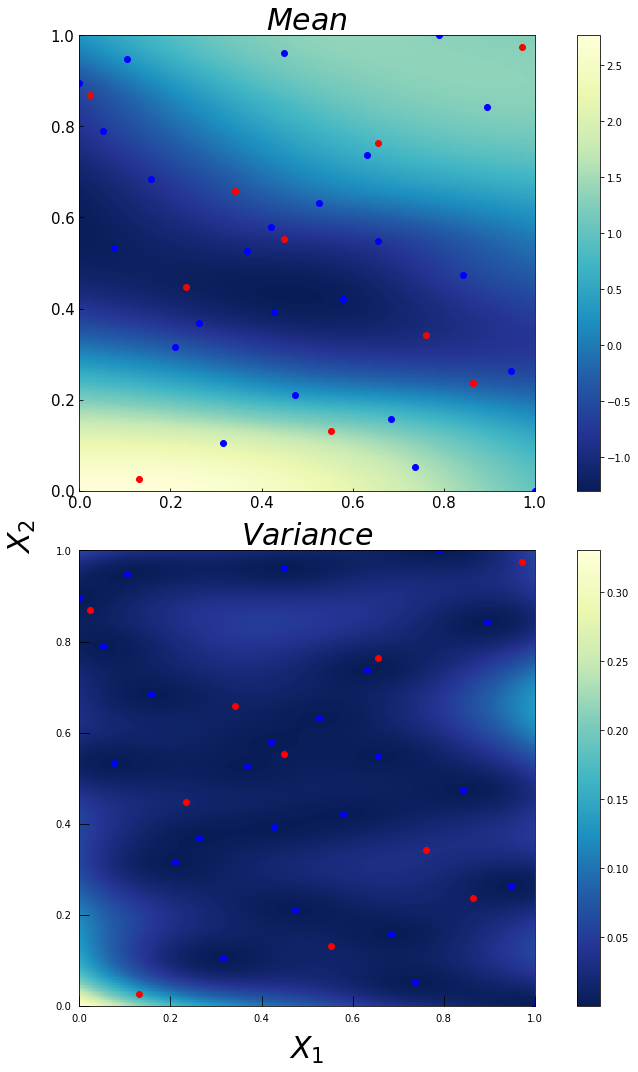

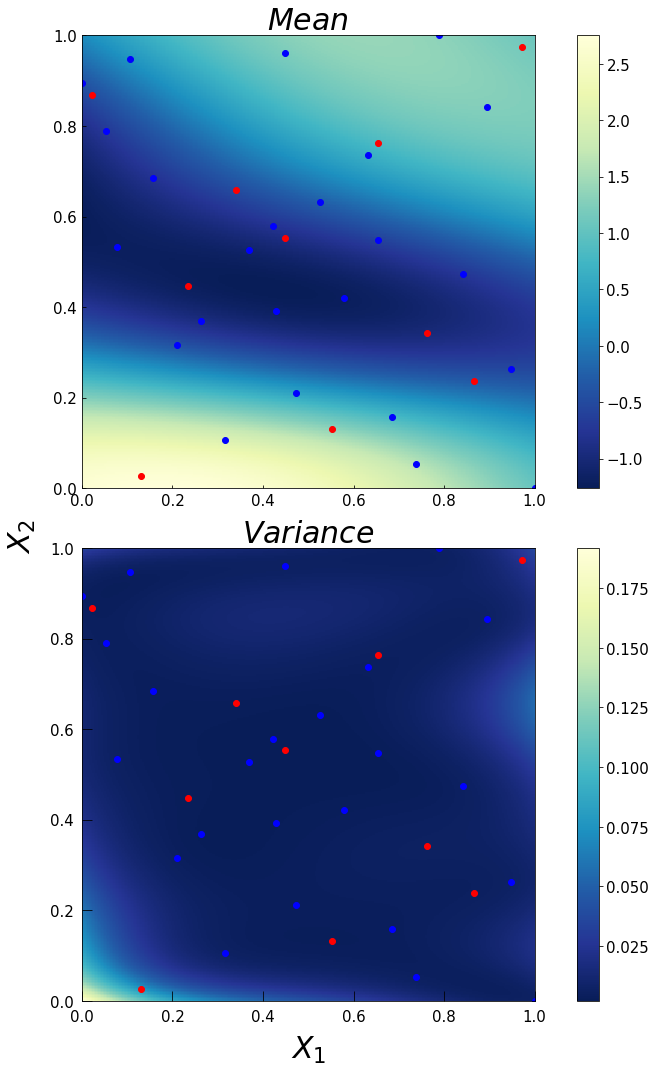

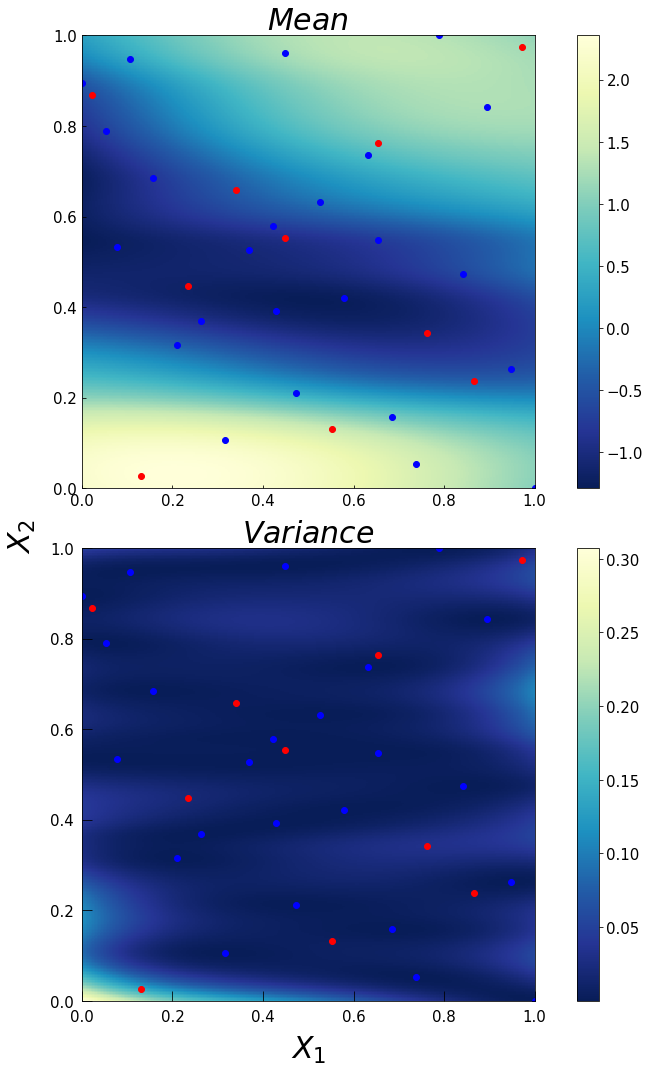

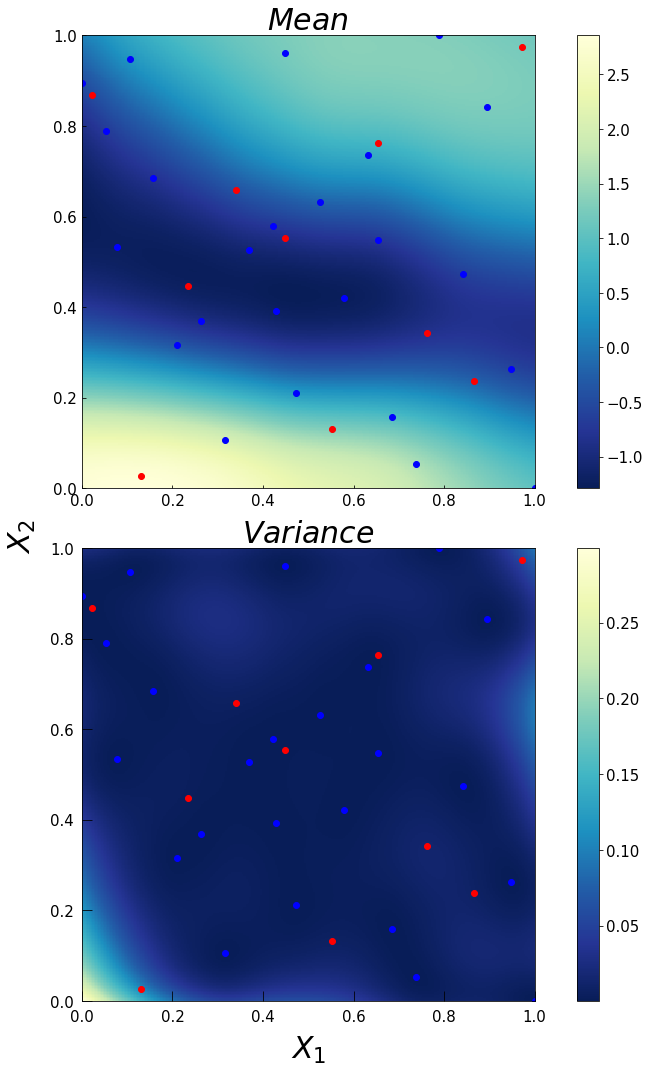

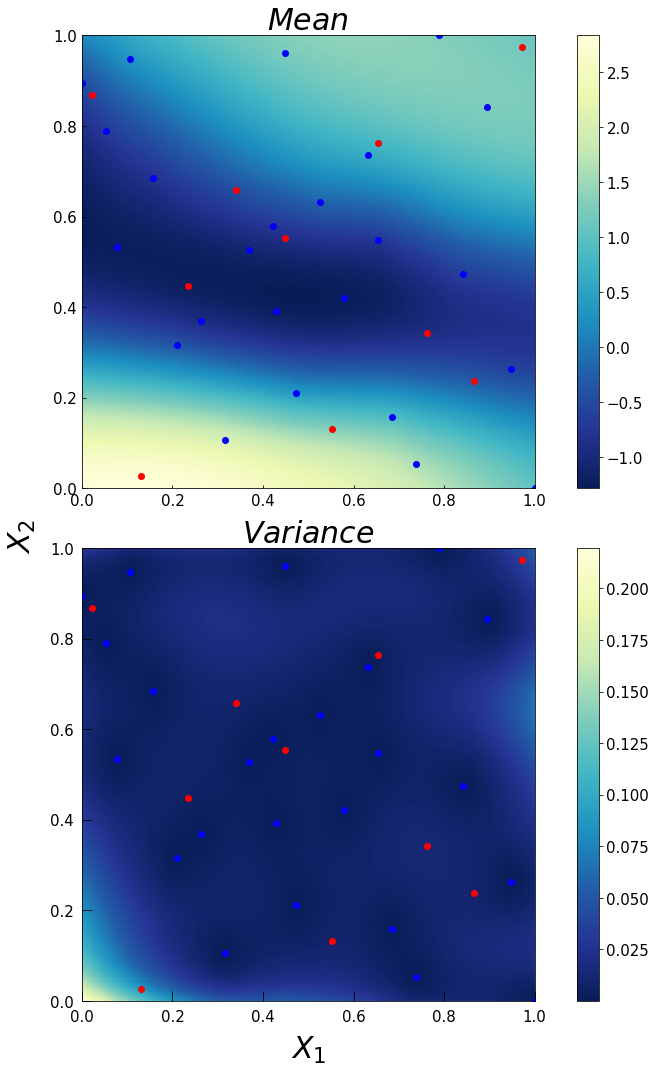

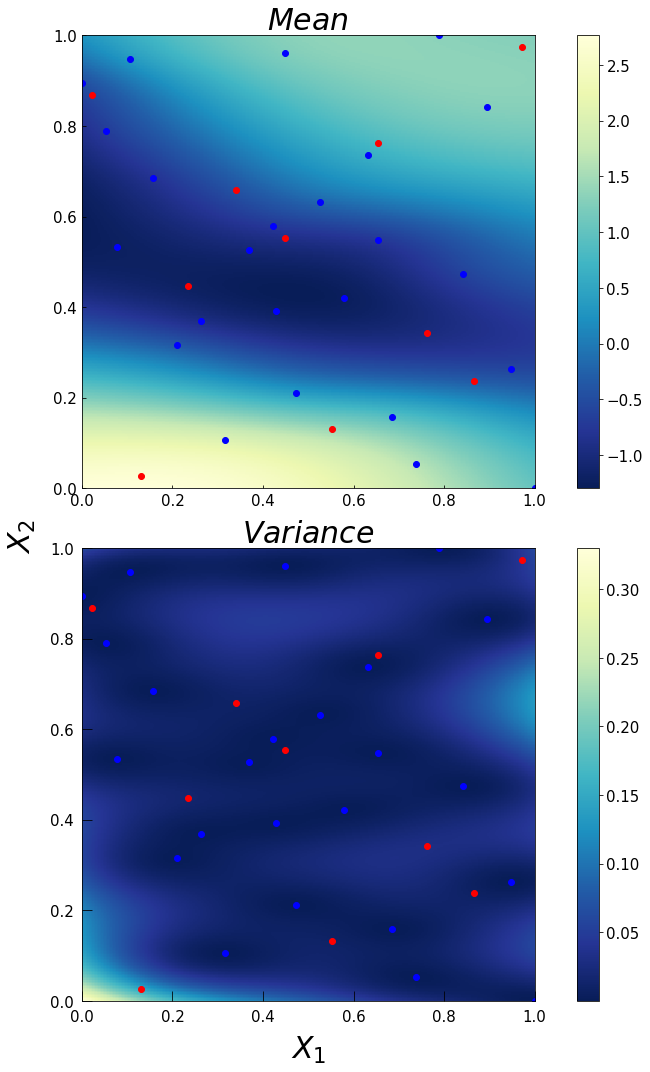

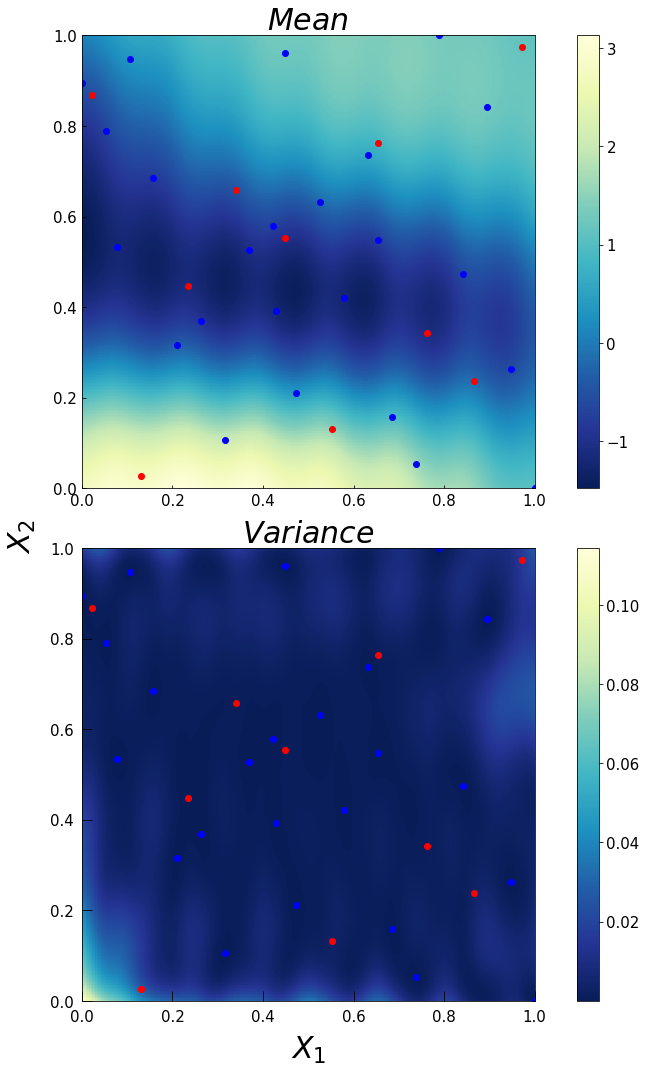

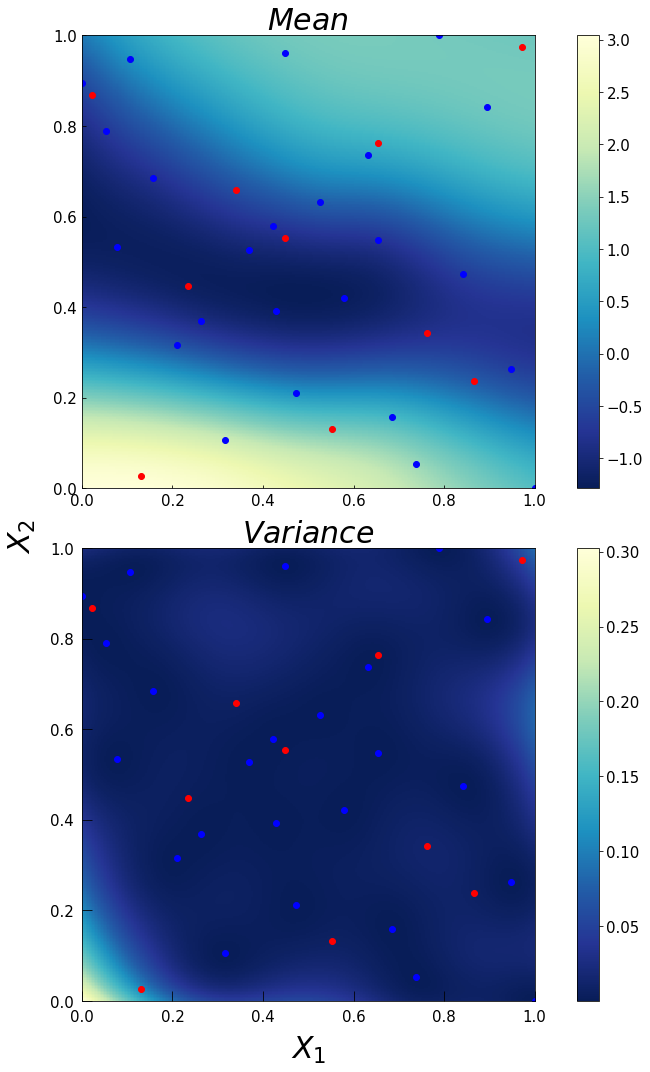

In [19]:
for mean, cov in zip(means, covs):
    plot_meanvar(mean, cov)

In [20]:
#Scaled values.
Xnew_b = norm_scaler.inverse_transform(Xnew)
Xtrain_b = norm_scaler.inverse_transform(Xtrain)
Xtest_b = norm_scaler.inverse_transform(Xtest)
Ytrain_b = standard_scaler.inverse_transform(Ytrain)
Ytest_b = standard_scaler.inverse_transform(Ytest)

In [21]:
#Function for plotting the rescaled mean and the variance of a gp model.

def plot_meanvar_sc(mean, cov):
    my_cmap_b="YlGnBu_r"
    fin_fig=plt.figure(figsize=(9, 15))

    # left plot - mean of gp fit
    ax1 = plt.subplot(211)

    # mean surface
    pcm1 = ax1.pcolor(Xi_b, Xj_b, mean.reshape(Xi_b.shape), cmap=my_cmap_b)

    # sample locations
    ax1.plot(Xtrain_b[:, 0], Xtrain_b[:, 1], 'o', color='blue')#, ax1.axis("square")
    ax1.plot(Xtest_b[:,0], Xtest_b[:,1], 'o', color='red')

    # annotations
    ax1.set_title("$\it{Mean}$", fontsize=25)
    fin_fig.colorbar(pcm1, ax=ax1)

    label_size = 15
    plt.tick_params(axis='both', which='both', labelsize=15, direction="in", pad=5)

    # right plot - variance of the gp
    ax2 = plt.subplot(212, sharex = ax1)

    # variance surface
    pcm2 = ax2.pcolor(Xi_b, Xj_b, cov.reshape(Xi_b.shape), cmap=my_cmap_b)

    # sample locations
    ax2.plot(Xtrain_b[:,0], Xtrain_b[:,1], 'o', color='blue')#, ax2.axis("square")
    ax2.plot(Xtest_b[:,0], Xtest_b[:,1], 'o', color='red')

    # annotations
    ax2.set_title("$\it{Variance}$", fontsize=25)
    fin_fig.colorbar(pcm2, ax=ax2)

    plt.rcParams['xtick.labelsize'] = label_size
    plt.rcParams['ytick.labelsize'] = label_size
    plt.tick_params(axis="both", size=10, direction="in", pad=8)

    # annotations

    plt.xlabel("Temperature", fontsize=25, labelpad=10, horizontalalignment='center')
    fin_fig.text(0.00, 0.5, "Duration", fontsize=25, ha='center', va='center', rotation='vertical')

    #plt.savefig(plots_path + 'scaled_mean_variance_2.png', facecolor='w', bbox_inches="tight", dpi=600)

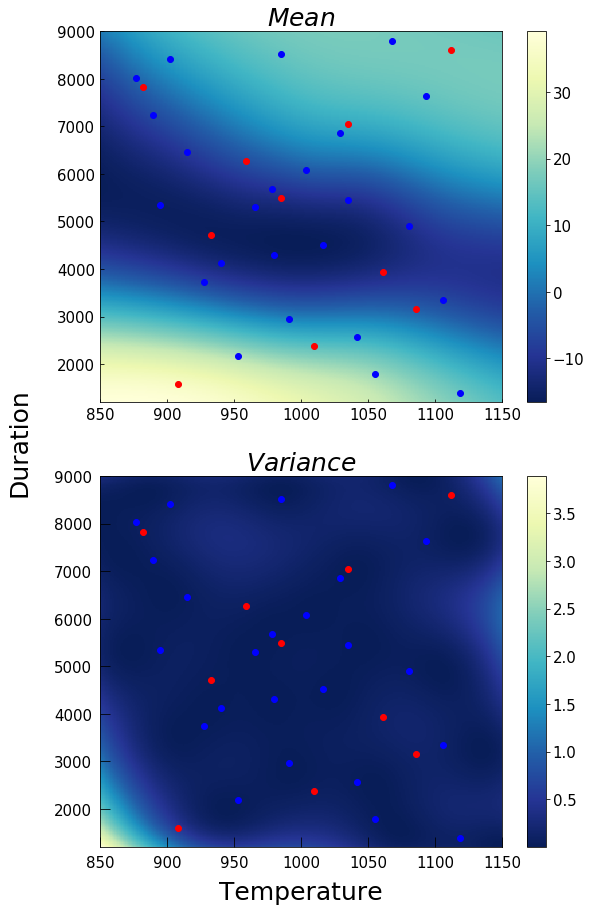

In [22]:
[Xi_b, Xj_b] = np.meshgrid(np.linspace(850, 1150, 300), np.linspace(1200, 9000, 300))   # [870,1125] - [1200-9000]
mean_b = standard_scaler.inverse_transform(mean)
cov_b = standard_scaler.inverse_transform(cov)

plot_meanvar_sc(mean_b, cov_b)

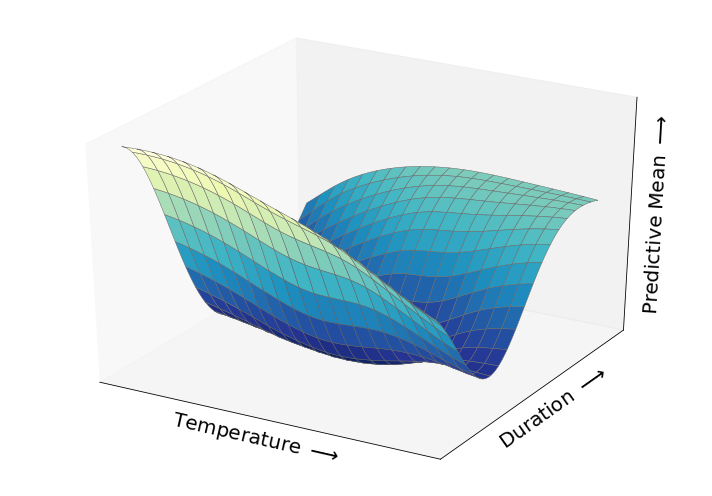

In [23]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize =(10, 7))

x,y = np.meshgrid(np.linspace(0, 1, 300), np.linspace(0, 1, 300))

surf = ax.plot_surface(x, y, mean.reshape(x.shape), rstride=15, cstride=15,
                       cmap='YlGnBu_r', edgecolors='dimgray', lw=0.5, antialiased=True)

ax.set_xlabel(r'Temperature $\longrightarrow$', fontsize = 20, labelpad=-5)
ax.set_ylabel(r'Duration $\longrightarrow$', fontsize = 20, labelpad=-5)
ax.set_zlabel(r'Predictive Mean $\longrightarrow$', fontsize = 20, labelpad=-5)

ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])
ax.xaxis.set_ticklabels([]), ax.yaxis.set_ticklabels([]), ax.zaxis.set_ticklabels([])

plt.tight_layout()
ax.grid(False)

#plt.savefig(plots_path + 'mean_surface_2.png', bbox_inches="tight",facecolor='w', dpi=600)
plt.show()

In [24]:
#Calculating the mean and the covariance at the grid.
mean, cov = m1.predict_noiseless(Xnew, full_cov=False)

In [25]:
#Model predictions at the testing points.

predicted_means=[]
for model in models:
    predicted_mean, predicted_cov = model.predict_noiseless(Xtest, full_cov=False)
    predicted_means.append(predicted_mean)

print(predicted_means[1])

[[-0.51163005]
 [ 2.68009417]
 [-1.2055635 ]
 [-0.41479111]
 [-0.87875414]
 [ 1.40837215]
 [ 0.80288907]
 [-0.96781405]
 [-0.31082704]
 [ 1.29712683]]


In [26]:
#MSE values for each model.

mse=[]
for i in range(8):
    mse.append(mean_squared_error(Ytest, predicted_means[i]))
    
print(mse)

[0.06231113540594828, 0.05269041550003388, 0.0866865553434591, 0.063631482811465, 0.05780415426716301, 0.05269143556498167, 0.07373493265306456, 0.05642731459356955]


In [27]:
#MAE values for each model.

mae=[]
for i in range(8):
    mae.append(mean_absolute_error(Ytest, predicted_means[i]))
    
print(mae)

[0.1968684022598145, 0.17033680431591922, 0.21421728981017604, 0.18786619602219495, 0.18690324998711372, 0.170337909379106, 0.2131201392489416, 0.17034441115505866]


In [28]:
total=np.add(mse,mae) #
print(total)
min(mse)

[0.25917954 0.22302722 0.30090385 0.25149768 0.2447074  0.22302934
 0.28685507 0.22677173]


0.05269041550003388

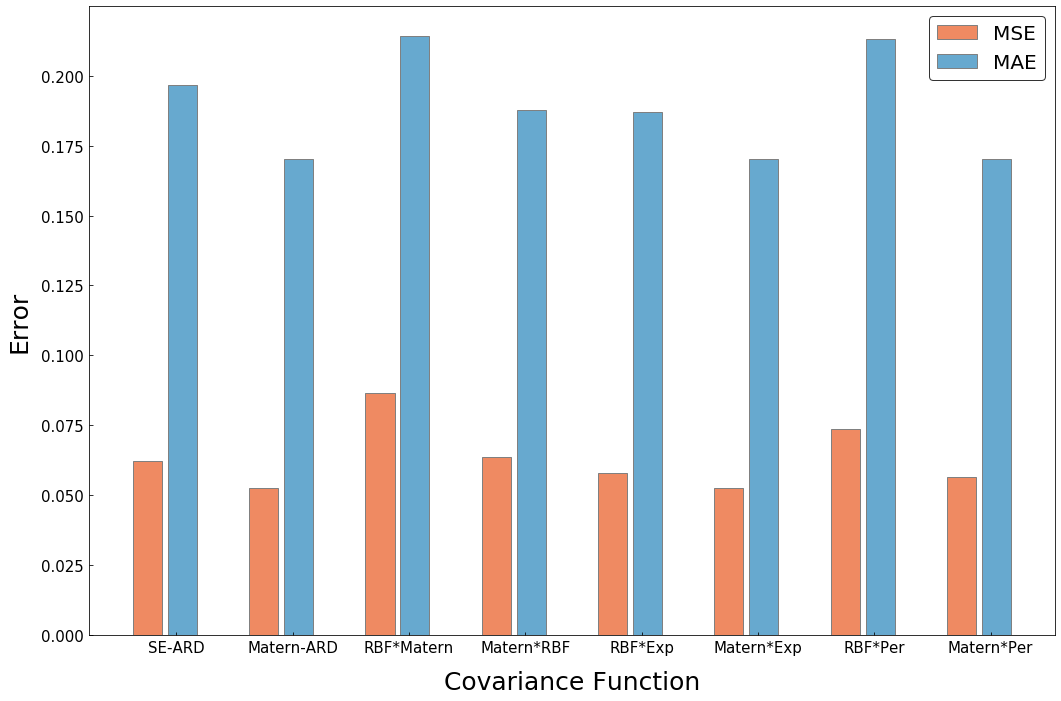

In [29]:
#Bar plot for the mse and mae values.

plt.rcParams.update({'font.size': 15})

barWidth = 0.25
fig = plt.subplots(figsize =(15, 10))
 
mse_x = np.arange(len(mae))
mae_x = [x + barWidth+0.05 for x in mse_x]

plt.bar(mse_x, mse, color ='#ef8a62', width = barWidth,
        edgecolor ='grey', label ='MSE')
plt.bar(mae_x, mae, color ='#67a9cf', width = barWidth,
        edgecolor ='grey', label ='MAE')

plt.xlabel('Covariance Function', fontsize=25, labelpad=15, horizontalalignment='center')
plt.ylabel('Error', fontsize=25, labelpad=10, horizontalalignment='center')

plt.xticks([r + barWidth for r in range(len(mae))],
        ['SE-ARD', 'Matern-ARD', 'RBF*Matern', 'Matern*RBF', 
         'RBF*Exp', 'Matern*Exp', 'RBF*Per', 'Matern*Per'])
plt.tick_params(axis='both', which='both', labelsize=15, direction="in", pad=5)

plt.tight_layout()
plt.legend(loc='best', fontsize=20, edgecolor='black')

#plt.savefig(plots_path + 'error_per_kernel_b.png', facecolor='w', dpi=600)
plt.show()

In [30]:
print(m)
print(m1.Mat32.lengthscale)


Name : GP regression
Objective : 6.8759948947194225
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    2.0255129304321398  |      +ve      |        
  rbf.lengthscale          |                  (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.007864811052608486  |      +ve      |        
  index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                       1.66808147  |      +ve      |        
  [1]    |                       0.56244844  |      +ve      |        


In [31]:
#Loading the model.
model = pickle.load(open(models_path + 'gp_model_b', "rb"))
print(model)
print(model.rbf.lengthscale)


Name : GP regression
Objective : 6.8759948947194225
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    2.0255129304321398  |      +ve      |        
  rbf.lengthscale          |                  (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.007864811052608486  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.73601687  |      +ve      |        
  [1]    |                     0.26279621  |      +ve      |        


In [32]:
#predict train
main_predicted_mean_tr, main_predicted_cov_tr = m1.predict_noiseless(Xtrain, full_cov=False)
main_predicted_mean_tr

array([[-0.45231065],
       [-0.68070724],
       [-1.22656133],
       [ 0.3251504 ],
       [-0.79935101],
       [-0.34977167],
       [-0.91555684],
       [ 2.04119996],
       [-1.0589276 ],
       [-0.73052495],
       [-1.21441777],
       [ 1.23890469],
       [ 0.37661326],
       [-0.184945  ],
       [-1.2516702 ],
       [ 0.63800835],
       [-0.73774681],
       [ 0.88877997],
       [ 1.62624526],
       [ 1.32396697],
       [-0.60995876],
       [ 1.28242273],
       [-0.56503092],
       [ 1.03618915]])

In [33]:
#predict test
main_predicted_mean_te, main_predicted_cov_te = m1.predict_noiseless(Xtest, full_cov=False)
main_predicted_mean_te

array([[-0.51163005],
       [ 2.68009417],
       [-1.2055635 ],
       [-0.41479111],
       [-0.87875414],
       [ 1.40837215],
       [ 0.80288907],
       [-0.96781405],
       [-0.31082704],
       [ 1.29712683]])

In [34]:
pc2_tr = standard_scaler.inverse_transform(main_predicted_mean_tr)
pc2_te = standard_scaler.inverse_transform(main_predicted_mean_te)

In [35]:
pc2_tr_df = pd.DataFrame(pc2_tr)
pc2_te_df = pd.DataFrame(pc2_te)
#pc2_tr_df.to_csv('./../../data/gp_predictions/GP2_tr.csv')
#pc2_te_df.to_csv('./../../data/gp_predictions/GP2_te.csv')

In [36]:
pc2_te[1]

array([34.46950427])

In [37]:
mse_tr = mean_squared_error(Ytrain, main_predicted_mean_tr)
mse_te = mean_squared_error(Ytest, main_predicted_mean_te)
print(mse_tr, mse_te)

2.655423840196611e-15 0.05269041550003388


In [38]:
mae_tr = mean_absolute_error(Ytrain, main_predicted_mean_tr)
mae_te = mean_absolute_error(Ytest, main_predicted_mean_te)
print(mae_tr, mae_te)

4.096457156011849e-08 0.17033680431591922


In [39]:
pc2_te[2]

array([-15.505118])

In [40]:
inv_list = np.zeros((10, 2))
inv_list[(0,0)] = 0.33192574
inv_list[(1,0)] = 0.30771514
inv_list

array([[0.33192574, 0.        ],
       [0.30771514, 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [41]:
lengthscales=norm_scaler.inverse_transform(inv_list)
lengthscales-876.375

array([[ 80.40901051, 518.625     ],
       [ 74.54399267, 518.625     ],
       [  0.        , 518.625     ],
       [  0.        , 518.625     ],
       [  0.        , 518.625     ],
       [  0.        , 518.625     ],
       [  0.        , 518.625     ],
       [  0.        , 518.625     ],
       [  0.        , 518.625     ],
       [  0.        , 518.625     ]])

In [42]:
print(lengthscales[0], lengthscales[1])

[ 956.78401051 1395.        ] [ 950.91899267 1395.        ]
